# Эконометрический анализ факторов заработной платы с помощью Python  

## 1. Формирование и подготовка выборки

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_stata("r33i_os_84.dta", convert_categoricals=False)

# заменяем служебные пропуски RLMS на NaN
df = df.replace({
    99999995: np.nan, 99999996: np.nan, 99999997: np.nan,
    99999998: np.nan, 99999999: np.nan
})

# фильтры варианта: год, регион, пол, возраст
df = df[
    (df["cc_int_y"] == 2024) &
    (df["region"] == 47) &
    (df["cch5"] == 1) &
    (df["cc_age"] >= 18) &
    (df["cc_age"] <= 55) &
    (df["cc_adult"] == 1)
]

# зарплата
df["wage"] = df["ccj10"]

# образование (0 школа, 1 ПТУ, 2 ВУЗ)
df.loc[df["cc_educ"] <= 14, "educ"] = 0
df.loc[(df["cc_educ"] >= 15) & (df["cc_educ"] <= 18), "educ"] = 1
df.loc[df["cc_educ"] >= 19, "educ"] = 2

# возраст
df["age"] = df["cc_age"]

# дети
df["is_children"] = df["ccj72_171"].replace({1: 1, 2: 0})

# продолжительность рабочего дня
df["work_hours"] = df["ccj6_1a"] + df["ccj6_1b"] / 60

# возраст окончания образования
df.loc[df["educ"] == 0, "educ_finish_age"] = 17
df.loc[df["educ"] == 1, "educ_finish_age"] = 19
df.loc[df["educ"] == 2, "educ_finish_age"] = 22

# прокси стаж
df['exp'] = df['ccj161_3y']
df["exp2"] = df["exp"] ** 2

# доп факторы: семейное положение и часы в неделю
df["marital_status"] = ((df["cc_marst"] == 2) | (df["cc_marst"] == 3)).astype(int)
df["hours_week"] = df["ccj6_2"]

# удаляем пропуски
df_final = df[[
    "wage", "educ", "age", "is_children",
    "work_hours", "exp", "exp2",
    "marital_status", "hours_week"
]].dropna()

# сохраняем итоговую выборку
df_final.to_csv("dataset_variant80.csv", index=False)

df_final.head()


,wage,educ,age,is_children,work_hours,exp,exp2,marital_status,hours_week
2551,42000.0,1.0,40.5,1.0,8.0,19.0,361.0,1,40.0
3329,42000.0,1.0,54.0,1.0,8.0,30.0,900.0,1,41.0
3337,45000.0,1.0,49.5,1.0,12.0,25.0,625.0,0,36.0
3341,118000.0,1.0,47.5,1.0,12.0,21.0,441.0,0,72.0
3349,82000.0,2.0,52.5,1.0,8.0,26.0,676.0,1,40.0


Основные факторы для анализа:

- wage - заработная плата, полученная за последние 30 дней по основному
месту работы после удержания налогов в рублях (зависимая переменная):
- educ — уровень образования, категориальная переменная с 3 значениями:
О — для индивидов, учившихся только в школе
1 — для индивидов, учившихся в ПТУ/техническом у чилище
2 — для индивидов, учившихся в институте, университете, академии
- age — возраст в годах (рассмотрите респондентов в возрасте 18-55 лет):
- is_children = 1, если у респондента есть хотя бы 1 ребенок, = 0 иначе;
- work_hours — количество часов, которое продолжается рабочий день (по ос-
новному рабочему месту).
- exp, exp2 — стаж работы (в годах) и квадрат стажа работы. В опросе РМЭ3 нет
переменной, содержащей информацию об общем стаже индивидов, поэтому
вам необходимо на основе имеющихся данных самостоятельно предложить
прокси-переменную для стажа.

Доп факторы для анализа:

- marital_status. Мужчины, состоящие в браке, как правило, зарабатывают больше — это устойчивый результат в литературе. Наличие семьи может повышать стабильность занятости и мотивацию к заработку.

- hours_week. Количество часов работы в неделю напрямую связано с уровнем дохода: большее количество отработанных часов означает большую занятость и, соответственно, более высокую заработную плату.

## 2. Описание выборки и генеральной совокупности

In [ ]:
print("исходный размер данных:", df.shape)
print("после фильтра по региону/полу/возрасту и удаления пропусков:", df_final.shape[0], "наблюдений,", df_final.shape[1], "переменных")

mean_wage = df_final["wage"].mean()
mean_age = df_final["age"].mean()
share_kids = df_final["is_children"].mean() * 100

print(f"\nсредняя зарплата в выборке: {mean_wage:.0f} рублей")
print(f"средний возраст: {mean_age:.1f} лет")
print(f"доля людей с детьми: {share_kids:.1f} %")


исходный размер данных: (81, 871)
после фильтра по региону/полу/возрасту и удаления пропусков: 46 наблюдений, 9 переменных

средняя зарплата в выборке: 62657 рублей
средний возраст: 39.5 лет
доля людей с детьми: 84.8 %


Полученная выборка включает мужчин 18–55 лет, проживающих в Орске и участвовавших в опросе RLMS в 2024 году. После всех фильтров осталось 46 человек. Средняя зарплата — около 62,6 тыс. рублей, средний возраст — 39,5 лет, и около 85% имеют детей.

Генеральная совокупность — все мужчины 18–55 лет, живущие в Орске и занятые на рынке труда в 2024 году.

Проверить репрезентативность можно, сравнив распределение ключевых характеристик (возраст, образование, состав семьи, занятость) в выборке с официальной статистикой или полной выборкой RLMS по этому региону. Если показатели похожи, выборка считается репрезентативной.

## 3. Описательные статистики переменных

In [ ]:
stats = df_final.describe().T
stats["range"] = stats["max"] - stats["min"]
stats[["min", "max", "mean", "std", "range"]]


,min,max,mean,std,range
wage,28000.0,170000.0,62656.521739,29631.774628,142000.0
educ,1.0,2.0,1.456522,0.503610,1.0
age,23.5,54.0,39.456522,7.276161,30.5
is_children,0.0,1.0,0.847826,0.363158,1.0
work_hours,8.0,12.0,8.913043,1.671009,4.0
exp,2.0,33.0,15.521739,7.497375,31.0
exp2,4.0,1089.0,295.913043,245.497212,1085.0
marital_status,0.0,1.0,0.804348,0.401085,1.0
hours_week,36.0,72.0,43.282609,7.311066,36.0


Выводы

- Зарплата сильно различается: от 28 тыс. до 170 тыс. рублей. Значит, в выборке есть и низко-, и высокооплачиваемые работники.

- Возраст — в среднем около 40 лет, стандартный рабочий возраст.

- Стаж — в среднем 15 лет, но различается от почти нулевого до очень большого (33 года).

- Рабочий день — около 9 часов, то есть многие работают чуть больше стандартных 8.

- Дети — большинство (примерно 85%) имеют хотя бы одного ребёнка.

- Образование — в основном среднее или среднее специальное (значения 1–2).

## 4. Квартили и межквартильный размах

In [ ]:
quartiles = df_final.quantile([0.25, 0.5, 0.75]).T
quartiles["IQR"] = quartiles[0.75] - quartiles[0.25]
quartiles


,0.25,0.5,0.75,IQR
wage,45000.0,55000.0,65000.00,20000.00
educ,1.0,1.0,2.00,1.00
age,35.0,38.0,45.00,10.00
is_children,1.0,1.0,1.00,0.00
work_hours,8.0,8.0,8.00,0.00
exp,10.0,16.0,20.75,10.75
exp2,100.0,256.0,430.75,330.75
marital_status,1.0,1.0,1.00,0.00
hours_week,40.0,40.0,48.00,8.00


- wage: 50% наблюдений находятся в диапазоне 45 000–65 000 руб., IQR = 20 000 — заметная вариативность доходов.

- educ: медиана = 1, 75% ≤ 2 — в выборке преобладает среднее и высшее образование.

- age: 50% респондентов в возрасте 35–45 лет, IQR = 10 — выборка сосредоточена в среднем трудоспособном возрасте.

- is_children: IQR = 0 — у большинства есть дети, переменная практически не варьируется.

- work_hours: IQR = 0 — стандартная продолжительность рабочего дня (8 часов).

- exp: 50% имеют стаж 10–20.75 лет, IQR = 10.75 — существенная дифференциация по опыту.

- exp2: высокая вариативность — обусловлена квадратичной формой признака.

- marital_status: IQR = 0 — большинство респондентов имеют одинаковый семейный статус.

- hours_week: 50% работают 40–48 часов в неделю, IQR = 8 — умеренная вариативность нагрузки.

## 5. Сравнение среднего, медианы и моды

In [ ]:
mean_vals = df_final.mean()
median_vals = df_final.median()
mode_vals = df_final.mode().iloc[0]

result = pd.DataFrame({
    "mean": mean_vals,
    "median": median_vals,
    "mode": mode_vals
})

result

,mean,median,mode
wage,62656.521739,55000.0,45000.0
educ,1.456522,1.0,1.0
age,39.456522,38.0,38.0
is_children,0.847826,1.0,1.0
work_hours,8.913043,8.0,8.0
exp,15.521739,16.0,10.0
exp2,295.913043,256.0,100.0
marital_status,0.804348,1.0,1.0
hours_week,43.282609,40.0,40.0


Выводы

- Зарплата: среднее (62,7 тыс.) больше медианы (55 тыс.), а мода ещё ниже (45 тыс.), значит распределение смещено вправо: есть несколько высоких зарплат, которые подтягивают среднее вверх.

- Возраст и стаж: среднее примерно равно медиане, мода совпадает или близка, значит распределение почти симметричное.

- Рабочие часы и часы в неделю: все три показателя совпадают, значит почти все работают одинаково.

- Образование и дети: мода и медиана совпадают, а среднее получается чуть выше, потому что в выборке есть часть людей с более высоким значением переменной.

В выборке распределения большинства переменных выглядят довольно ровными и симметричными — у возраста, стажа и рабочих часов среднее, медиана и мода почти совпадают. Только зарплата заметно смещена вправо.

## 6. Анализ выбросов (Boxplot)

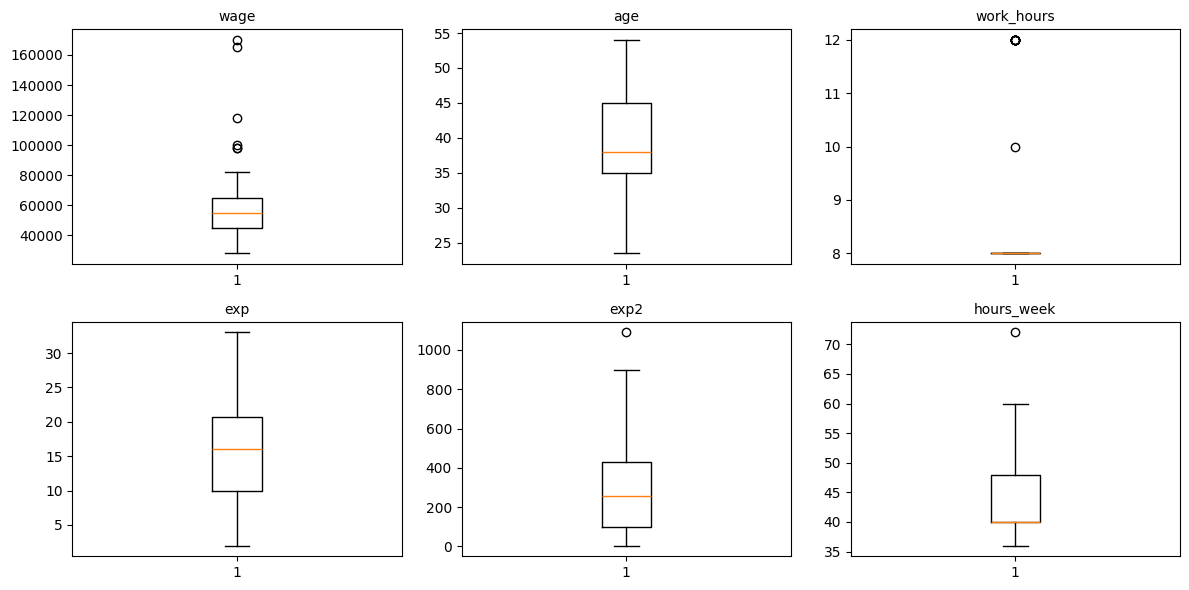

In [ ]:
import matplotlib.pyplot as plt

quant_vars = ["wage", "age", "work_hours", "exp", "exp2", "hours_week"]

plt.figure(figsize=(12, 6))

for i, var in enumerate(quant_vars, 1):
    plt.subplot(2, 3, i)
    plt.boxplot(df_final[var].dropna())
    plt.title(var, fontsize=10)
    plt.tight_layout()

plt.show()


Выбросы:

- wage — выбросы есть: несколько наблюдений с очень высокой зарплатой сильно выделяются.

- age — выбросов нет.

- work_hours — выбросы есть, редкие значения выше 8 часов (10–12).

- exp — выбросов нет, все значения выглядят реалистично.

- exp2 — выбросы есть, но это естественно: большие значения стажа дают резко увеличенный квадрат.

- hours_week — есть выбросы: одно наблюдение около 72 часов сильно выделяется.

## 7. Анализ распределений и показателей асимметрии

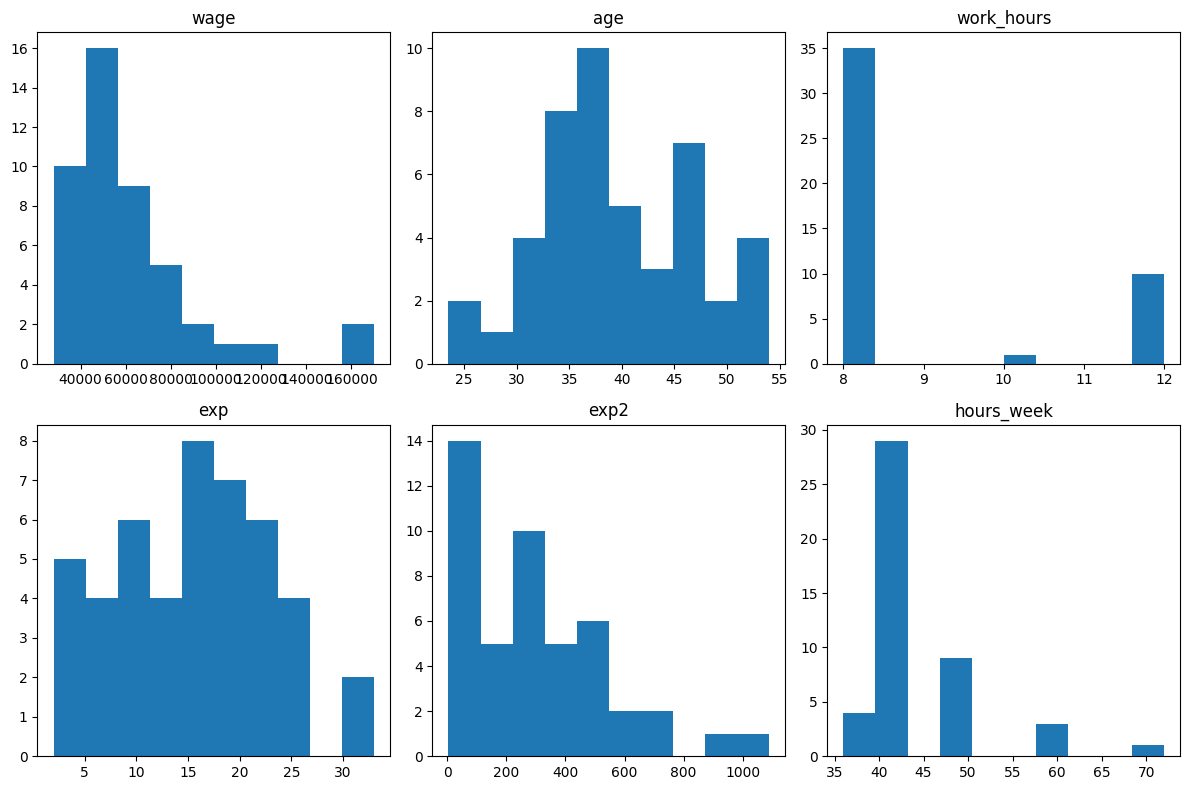

,skewness,kurtosis
wage,2.109208,4.728997
age,0.109301,-0.387094
work_hours,1.294398,-0.279369
exp,0.067189,-0.589425
exp2,1.079937,1.127915
hours_week,2.086704,4.433595


In [ ]:
from scipy.stats import skew, kurtosis

quant_vars = ["wage","age","work_hours","exp","exp2","hours_week"]

plt.figure(figsize=(12, 8))
for i, var in enumerate(quant_vars, 1):
    plt.subplot(2, 3, i)
    plt.hist(df_final[var], bins=10)
    plt.title(var)
plt.tight_layout()
plt.show()

skew_vals = df_final[quant_vars].apply(skew)
kurt_vals = df_final[quant_vars].apply(kurtosis)

stats_sk = pd.DataFrame({
    "skewness": skew_vals,
    "kurtosis": kurt_vals
})

stats_sk


Выводы

- wage: сильная правая асимметрия (skewness около 2). есть редкие высокие зарплаты, которые вытягивают хвост.
Kurtosis > 4, распределение остроконечное, с выбросами.

- age: практически симметричное распределение (skewness около 0.1).
Kurtosis около 0, форма близка к нормальной.

- work_hours: смещение вправо (skewness около 1.29) — много людей с 8 часами, редкие значения 10–12.
Kurtosis около 0, распределение широкое, но без сильной остроты.

- exp: симметричное распределение (skewness около 0.07).
Kurtosis < 0, более плоское, чем нормальное.

- exp2: выраженная правая асимметрия (skewness около 1.07), но это нормально, т.к. большие стажи дают очень большие квадраты.

- hours_week: сильная правая асимметрия (skewness около 2.08).
редкие значения 60–70 часов формируют длинный хвост.
Kurtosis > 4, есть выбросы.

## 8. Структура выборки по уровню образования

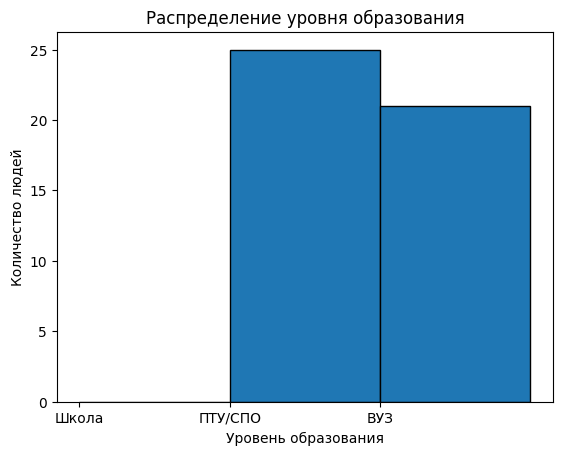

In [ ]:
plt.hist(df_final["educ"], bins=[0,1,2,3], edgecolor='black')
plt.xticks([0, 1, 2], ["Школа", "ПТУ/СПО", "ВУЗ"])
plt.title("Распределение уровня образования")
plt.xlabel("Уровень образования")
plt.ylabel("Количество людей")
plt.show()

- В выборке нет людей только со школьным образованием.

- Больше всего респондентов имеют ПТУ/СПО — эта группа самая крупная.

- Чуть меньше людей имеют высшее образование, но их тоже много.

## 9. Корреляционный анализ переменных

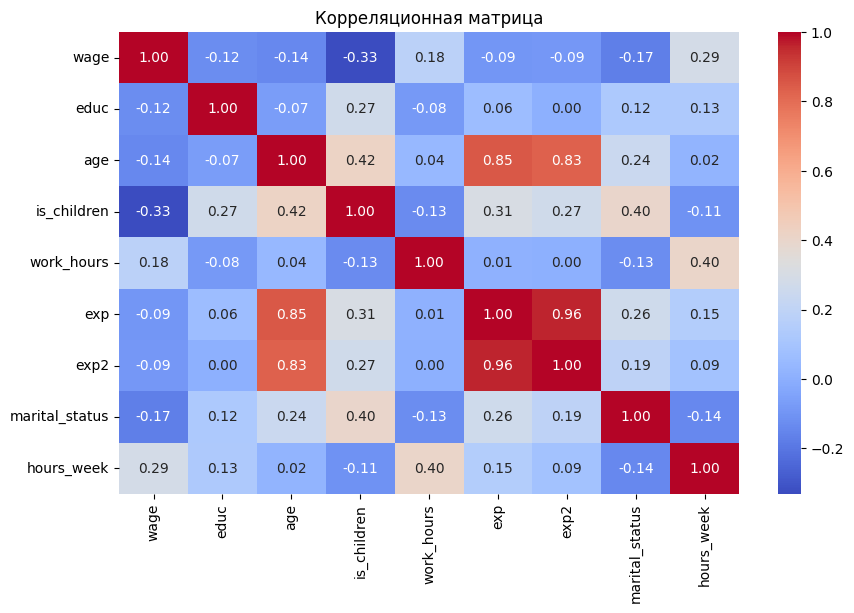

,wage,educ,age,is_children,work_hours,exp,exp2,marital_status,hours_week
wage,1.000000,-0.124770,-0.143182,-0.331245,0.180788,-0.094822,-0.091365,-0.172191,0.287468
educ,-0.124770,1.000000,-0.067236,0.266784,-0.083813,0.059111,0.003204,0.121974,0.127139
age,-0.143182,-0.067236,1.000000,0.417934,0.041719,0.851192,0.831616,0.244496,0.020914
is_children,-0.331245,0.266784,0.417934,1.000000,-0.132149,0.307307,0.266801,0.401312,-0.108988
work_hours,0.180788,-0.083813,0.041719,-0.132149,1.000000,0.007249,0.002365,-0.125419,0.404051
exp,-0.094822,0.059111,0.851192,0.307307,0.007249,1.000000,0.963270,0.263789,0.147658
exp2,-0.091365,0.003204,0.831616,0.266801,0.002365,0.963270,1.000000,0.189399,0.087846
marital_status,-0.172191,0.121974,0.244496,0.401312,-0.125419,0.263789,0.189399,1.000000,-0.139868
hours_week,0.287468,0.127139,0.020914,-0.108988,0.404051,0.147658,0.087846,-0.139868,1.000000


In [ ]:
import seaborn as sns

corr = df_final.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

corr

Выводы:
- Возраст сильно связан со стажем (corr = 0.85–0.96) — чем старше, тем больше опыт.

- Зарплата слабо связана с опытом (corr = –0.09) — в выборке стаж почти не влияет на доход.

- Зарплата чуть растёт с часами в неделю (corr = 0.29).

- Зарплата меньше у тех, у кого есть дети (corr = –0.33).

- Образование почти ни с чем не связано (corr около 0).

- Семейный статус умеренно связан с наличием детей (corr = 0.40).

- Work_hours почти не коррелирует ни с чем, потому что почти все работают по 8 часов.

## 10. Спецификация модели заработной платы

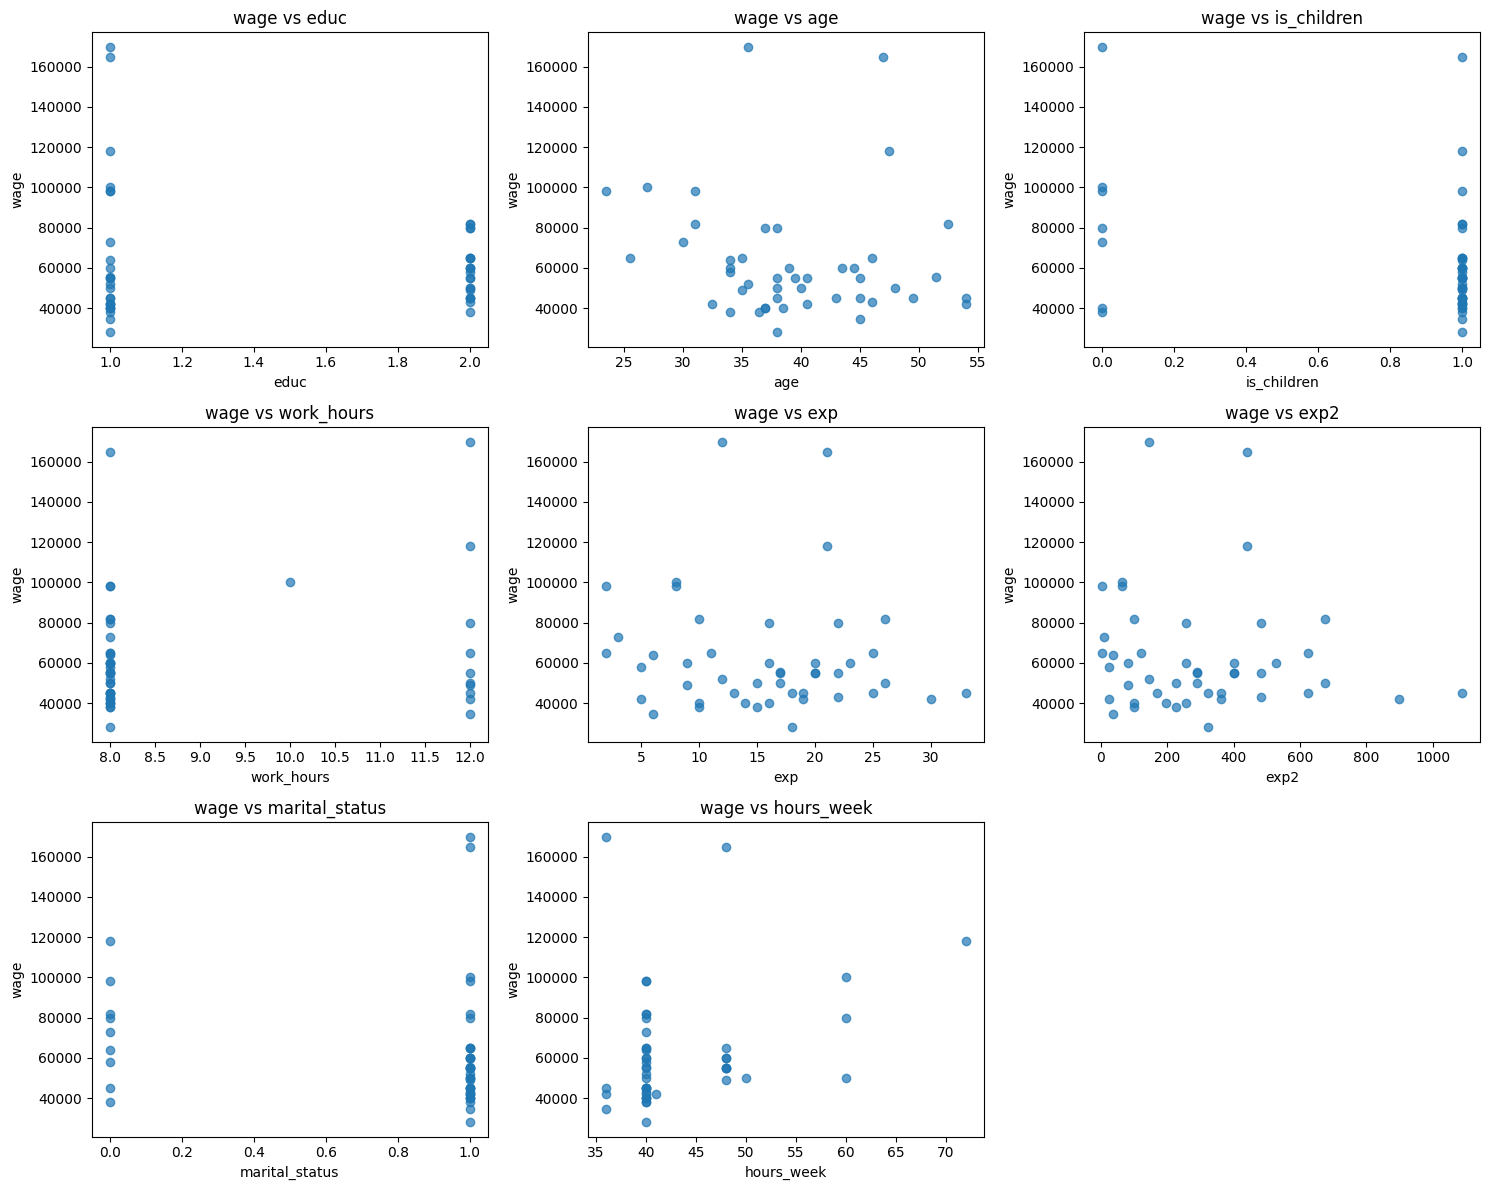

In [ ]:
vars_to_plot = ["educ", "age", "is_children", "work_hours",
                "exp", "exp2", "marital_status", "hours_week"]

plt.figure(figsize=(15, 12))

for i, var in enumerate(vars_to_plot, 1):
    plt.subplot(3, 3, i)
    plt.scatter(df_final[var], df_final["wage"], alpha=0.7)
    plt.title(f"wage vs {var}")
    plt.xlabel(var)
    plt.ylabel("wage")

plt.tight_layout()
plt.show()


Выводы

- educ: люди с высшим образованием (2) в среднем зарабатывают больше, чем с средним профобразованием (1).
Точки выше — это их зарплаты.

- age: чёткой связи нет. Зарплаты разбросаны, возраст влияет слабо.

- is_children: разницы почти нет, дети не связаны с зарплатой.

- work_hours: большинство работает одинаково, поэтому связь слабая.

- exp и exp2: с небольшим ростом опыта зарплата подрастает, но сильной связи нет, точки вразброс.

- marital_status: женатые имеют немного выше зарплаты, но различия небольшие.

- hours_week: кто работает больше часов, тот может зарабатывать больше, но зависимость всё ещё слабая.

## 11. Оценка модели МНК (OLS)

In [ ]:
import statsmodels.api as sm

X = df_final[[
    "educ", "age", "is_children", "work_hours",
    "exp", "exp2", "marital_status", "hours_week"
]]
y = df_final["wage"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.039
Date:                Sun, 16 Nov 2025   Prob (F-statistic):              0.426
Time:                        17:44:37   Log-Likelihood:                -533.75
No. Observations:                  46   AIC:                             1086.
Df Residuals:                      37   BIC:                             1102.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.266e+04   5.14e+04      0.

Выводы:

Модель слабая:

- R^2 = 0.183 — модель объясняет только 18% вариации зарплат.

- Все коэффициент не значимы на уровне 5%, значит статистически значимых факторов в модели нет.

Причины слабой значимости:

- маленькая выборка (46 наблюдений);

- сильная вариативность зарплат;

- низкое разнообразие в переменных (почти у всех 8 рабочих часов, близкие уровни опыта).

Эффекты:

- hours_week - положительный эффект (больше часов → больше зарплата)

- educ - отрицательный знак, но незначим (скорее шум)

- exp и exp2 маленькие и тоже незначимы

Уравнение:

$$
\widehat{wage} =
42660
- 5018.56\, educ
- 101.73\, age
- 2071.12\, is\_children
+ 620.09\, work\_hours
- 248.40\, exp
+ 4.26\, exp^{2}
- 206.78\, marital\_status
+ 1065.29\, hours\_week
$$


## 12. Проверка значимости модели в целом (F-тест)

Тест на незначимость модели в целом:
$$
H_0: \beta_1=\beta_2=\dots=\beta_k = 0 \\
H_1: \text{хотя бы одно } \beta_j \ne 0 \\
$$

Используем F статистику.

$
F = \frac{R^2 / k}{(1 - R^2) / (n - k - 1)} = \frac{0.183 / 8}{(1-0.183)/37} = 1.04\\
\alpha = 0.05 \\
k=8 \\
n−k−1=37 \\
$

Критическое значение:
$
F_{0.975;8;37}=2.79 \\
$

Критическая область:
$
(-\infty, -F_{0.975;8;37}) \cup (F_{0.975;8;37}, \infty) \\
(-\infty, -2.79) \cup (2.79, \infty)
$


$
F < F_{0,975;8;37} \\
1.04 < 2.79 \\
$

Значит не отвергаем гипотезу $H_0$, модель незначима в целом на уровне 5%.

## 13. Тестирование гипотезы об отдельном коэффициенте (t-тест)

Проверка гипотезы для коэффициента при переменной hours_week:

$
\begin{aligned}
H_0 &: \beta_{\text{hours\_week}} = 0 \\
H_1 &: \beta_{\text{hours\_week}} \neq 0
\end{aligned}
$

Из результатов регрессии:
$
\hat\beta = 1065.29, \\
SE = 723.05,\\
$

Используем t-статистику:

$
t = \frac{\hat\beta}{SE} = 1065.29 / 723.05 = 1.473
$

Критическое значение:
$
t_{0.975;37} = 2.026
$

Критическая область:
$
(-\infty, -t_{0.975;37}) \cup (t_{0.975;37}, \infty) \\
(-\infty, -2.026) \cup (2.026, \infty)
$

Проверка:
$
t < t_{0.975;37} \\
1.473 < 2.026 \\
$

Следовательно не отвергаем $H_0$. Коэффициент при $hours\_week$ незначим на уровне 5%.  

Если бы был значим, то при увеличении количества рабочих часов в неделю на 1 час зарплата увеличивалась бы в среднем на 1065 рублей, при прочих равных. Но у нас он не значим, делать такие выводы нельзя.


## 14. Совместная проверка коэффициентов (F-тест ограничений)


In [ ]:
import statsmodels.api as sm

X_full = df_final[["educ", "age", "is_children", "work_hours",
             "exp", "exp2", "marital_status", "hours_week"]]

X_full = sm.add_constant(X_full)
y = df_final["wage"]

model_full = sm.OLS(y, X_full).fit()
SSR_UR = model_full.ssr


X_rest = df_final[["educ", "is_children", "work_hours",
             "exp2", "marital_status", "hours_week"]]

X_rest = sm.add_constant(X_rest)

model_rest = sm.OLS(y, X_rest).fit()
SSR_R = model_rest.ssr

print("RSS полной модели (UR):", SSR_UR)
print("RSS ограниченной модели (R):", SSR_R)


RSS полной модели (UR): 32266498148.46258
RSS ограниченной модели (R): 32287045764.21355


Тест на незначимость модели в целом:
$$
H_0: \beta_{exp}=\beta_{exp} = 0 \\
H_1: \text{хотя бы одно } \beta_j \ne 0 \\
$$

Используем F статистику.

$
F = \frac{(RSS_R-RSS_{UR}) / q}{(RSS_{UR}) / (n - k - 1)} = \frac{(32287045764.214 - 32266498148.463) / 2}{(32266498148.463)/37} = 11.78\\
\alpha = 0.05 \\
k=8 \\
n−k−1=37 \\
$

Критическое значение:
$
F_{0.975;8;37}=2.79 \\
$

Критическая область:
$
(-\infty, -F_{0.975;8;37}) \cup (F_{0.975;8;37}, \infty) \\
(-\infty, -2.79) \cup (2.79, \infty)
$


$
F > F_{0,975;8;37} \\
11.78 > 2.79 \\
$

Значит отвергаем гипотезу $H_0$, пара переменных age и exp совместно значимы в модели.

## 15. Диагностика остатков модели

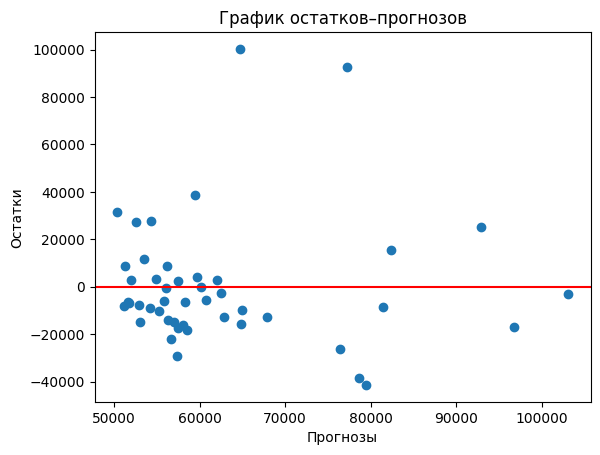

In [ ]:
import matplotlib.pyplot as plt

y_pred = model.predict(X)
residuals = model.resid

plt.scatter(y_pred, residuals)
plt.axhline(0, color='red')
plt.xlabel("Прогнозы")
plt.ylabel("Остатки")
plt.title("График остатков–прогнозов")
plt.show()


Остатки распределены неравномерно и сильно разбросаны, особенно при больших значениях прогноза.
Это показывает, что модель плохо объясняет данные и даёт неточные прогнозы для части наблюдений.

## 16. Сравнение и отбор спецификаций модели



Все коэффициенты в полной модели оказалися незначимым на 5% уровне — p-value у всех больше 0.05.

Значит, если строго следовать условию, в модели остаётся только константа.



$$
\widehat{wage} =
42660
$$

Это просто среднее значение заработной платы из выборки.

Если сравнивать с моделью в п.10, то теперь количество переменных = 0, а не 9. Также R^2 = 0, а не 0.183. Такая же ситуация с R^2 adj. По этим критериям мы можем сравнить модели. Также можно использовать AIC и BIC.

Вывод: Полная модель, хоть и даёт незначимые коэффициенты, всё же объясняет часть вариации зарплат.
Модель только с константой практически бесполезна.

## 17. Тестирование и корректировка выбросов

In [ ]:
import numpy as np
import statsmodels.api as sm

# модель
cols = ["educ","age","is_children","work_hours","exp","exp2","marital_status","hours_week"]
X = sm.add_constant(df_final[cols])
y = df_final["wage"]
model = sm.OLS(y, X).fit()
inf = model.get_influence()

# IQR
iqr_outliers = {}
for col in ["wage","educ","age","work_hours","exp","exp2","hours_week"]:
    Q1, Q3 = df_final[col].quantile(0.25), df_final[col].quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers[col] = df_final[(df_final[col] < Q1 - 1.5*IQR) | (df_final[col] > Q3 + 1.5*IQR)].index.tolist()

# Leverage
lev = inf.hat_matrix_diag
lev_pos = np.where(lev > 2*(X.shape[1])/X.shape[0])[0]
lev_idx = df_final.index[lev_pos].tolist()

# Cook
cooks = inf.cooks_distance[0]
cooks_pos = np.where(cooks > 4/X.shape[0])[0]
cooks_idx = df_final.index[cooks_pos].tolist()

print("IQR:", iqr_outliers)
print("Leverage idx:", lev_idx)
print("Cook idx:", cooks_idx)

out_idx = set(
    iqr_outliers["wage"]
    + iqr_outliers["work_hours"]
    + iqr_outliers["hours_week"]
    + iqr_outliers["exp2"]
    + lev_idx
    + cooks_idx
)

df_clean = df_final.drop(index=out_idx)

X_clean = sm.add_constant(df_clean[cols])
y_clean = df_clean["wage"]
model_clean = sm.OLS(y_clean, X_clean).fit()

print("Размер исходных данных:", len(df_final))
print("Размер после удаления выбросов:", len(df_clean))
print(model_clean.summary())


IQR: {'wage': [3341, 7801, 7828, 11124, 11127, 11157], 'educ': [], 'age': [], 'work_hours': [3337, 3341, 3353, 5887, 7828, 8615, 9523, 10524, 10536, 11124, 11155], 'exp': [], 'exp2': [8206], 'hours_week': [3341]}
Leverage idx: [3337, 3341, 3353, 8206, 8615]
Cook idx: [3341, 7801, 7828, 8614]
Размер исходных данных: 46
Размер после удаления выбросов: 30
                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     1.734
Date:                Sun, 16 Nov 2025   Prob (F-statistic):              0.153
Time:                        19:51:18   Log-Likelihood:                -320.87
No. Observations:                  30   AIC:                             657.7
Df Residuals:                      22   BIC:                             669.0
Df Model:    

Я удалил выбросы, которые были в модели.

Основные изменения:

- R^2 adj немного вырос (с 0.183 до 0.356), модель объясняет больше вариации зарплаты.

- R^2 adj вырос (с 0.007 до 0.151), но остался низким, качество всё ещё слабое.

- P-value F-теста снизилось (с 0.426 до 0.153), но модель всё ещё статистически незначима.

Итог: удаление выбросов улучшило модель (выше R², меньше шум), но значимых коэффициентов всё равно нет — модель остаётся слабой.



## 18. Точечный и интервальный прогноз

In [ ]:
new_person = pd.DataFrame([{
    "educ": 2,
    "age": 40,
    "is_children": 1,
    "work_hours": 8,
    "exp": 15,
    "exp2": 225,
    "marital_status": 1,
    "hours_week": 40
}])

new_person = sm.add_constant(new_person, has_constant='add')

new_person = new_person[model_full.model.exog_names]

pred = model_full.get_prediction(new_person)
pred.summary_frame()


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,52446.980724,8055.612997,36124.758384,68769.203065,-9574.383939,114468.345388


Точечный прогноз заработной платы:

Модель:
$$
\widehat{wage}
= 42660
-5018.56\, educ
-101.73\, age
-2071.12\, is\_children
+620.09\, work\_hours
-248.40\, exp
+4.26\, exp^2
-206.78\, marital\_status
+1065.29\, hours\_week
$$

Характеристики индивида:
- educ=2,
- age=40,
- is_children=1,
- work_hours=8,
- exp=15,
- exp^2=225,
- marital_status=1,
- hours_week=40


Подставляем:
$$
\widehat{wage} =
42660
- 5018.56 \cdot 2
- 101.73 \cdot 40
- 2071.12 \cdot 1
+ 620.09 \cdot 8
- 248.40 \cdot 15
+ 4.26 \cdot 225
- 206.78 \cdot 1
+ 1065.29 \cdot 40
$$


$\widehat{wage} \approx 75480 \text{ руб.}$


Доверительный интервал прогноза:
$
\widehat{wage} \pm t_{0.975;37}\cdot SE(\widehat{y}_{pred})
$

Критическое значение:
$
t_{0.975;37} = 2.026
$

$SE(\widehat{y}_{pred})$ посчитал с помощью кода выше, но можно также было через корреляционную таблицу и значение дисперсии. Берем значение $mean_se = 8055$. Так просто гораздо проще и быстрее.

Подставляем в формулу:
$
75480 \pm 2.026\cdot 8055
$

$
CI_{95\%} = [59160,57; 91799,43]
$

## 19. Общие итоги проекта

- Собрал и подготовил данные, очистил выборку и создал нужные переменные.

- Проанализировал данные — посмотрел распределения, разброс значений и возможные выбросы.

- Выяснил, какие факторы связаны с уровнем заработной платы.

- Построил регрессионную модель и проверил, какие переменные действительно влияют на доход.

- Улучшил модель, убрав незначимые факторы, и проверил её качество.

- Сделал прогноз заработной платы для заданных характеристик и оценил доверительный интервал.